In [48]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import itertools

## Lendo o Dataset

In [49]:
def csv_replace(csv_name):
    text = open(csv_name, 'r')
    text = ''.join(i for i in text).replace(';', ',')
    export = open(csv_name, 'w')
    export.writelines(text)
    export.close()

In [50]:
csv_replace('export_result.csv')
csv_replace('export_indicator.csv')
csv_replace('export_history.csv')

In [51]:
history = pd.read_csv('export_history.csv')
result = pd.read_csv('export_result.csv')
indicator = pd.read_csv('export_indicator.csv')


## Separando o Dataset por episódio

In [52]:
def episode_split(dataframe,episode_id):
    dfcopy = dataframe.copy()
    episode = dfcopy.loc[dfcopy['episode_id'] == episode_id]
    aux = episode[['team_id', 'player_id', 'indicator_id','score']]
    aux_pivot = aux.pivot(index='player_id', columns='indicator_id', values='score')
    aux_pivot = aux_pivot.replace(np.nan, 0)
    return aux_pivot


## Normalizando o Dataset

In [53]:
def standardizing(X_pre):
    from sklearn.preprocessing import StandardScaler
    std = StandardScaler()
    X = std.fit_transform(X_pre)
    X = pd.DataFrame(X)
    X.index = X_pre.index
    X.columns = X_pre.columns

    return X


## Aplicando o Elbow Method para encontrar a melhor quantidade de grupos para o determinado episódio

In [54]:
#É nescessário a análise visual do gráfico para determinar o número de grupos
def elbow_method(X,n_groups):
    n_groups += 1
    from sklearn.cluster import KMeans
    cluster_ss = []
    for i in range(1, n_groups):
        kmeans = KMeans(n_clusters= i, init='k-means++', random_state=42)
        kmeans.fit(X)
        cluster_ss.append(kmeans.inertia_)
    plt.plot(range(1, n_groups), cluster_ss)
    plt.ylabel('Sum of Squares')
    plt.xlabel('Number of groups')



## Construindo o modelo

In [55]:
def clustering(X,n_groups):
    from sklearn.cluster import KMeans
    kmeans_model = KMeans(n_groups, init='k-means++', random_state=42)
    y_pred = kmeans_model.fit_predict(X)
    return y_pred


In [56]:
def lowest_indicator(X,groups):
    n_groups = len(np.unique(groups))
    dictionary = {}
    data = pd.DataFrame()
    list_2 = []
    for i in range(n_groups):
        aux = X[groups == i]
        aux = aux.replace(0, np.nan)
        aux['min_value'] = aux.idxmin(axis=1)
        m_freq = aux['min_value'].value_counts().idxmax(axis=1)
        list_of_tuples = list(zip(aux.index, itertools.repeat(m_freq)))
        aux_data = pd.DataFrame(list_of_tuples)
        data = data.append(aux_data, ignore_index=True)
    data.columns = ['player', 'id']
    data = data.sort_values(['player'], ascending=True)
    return data

In [57]:
def notification(deficit, indicator):
    dfcopy = indicator.copy()
    notification = []
    aux = dfcopy[['id', 'name']]
    deficit = deficit.merge(aux, on='id', how='left')
    for i in range(len(deficit)):
        player = deficit.at[i,'player']
        indicator_name = deficit.at[i,'name']
        notification.append(f'O player {player} é deficitário no indicador {indicator_name}')
    return notification
    

In [58]:
#Cabe ao usuário avaliar o melhor numero de grupos, sendo este o menor valor a partir do ponto em que se nota uma queda baixa em relação a soma dos quadrados
def execute_1(result, episode_id, n_groups):
    X_pre = episode_split(result, episode_id)
    X = standardizing(X_pre)
    elbow_method(X, n_groups)
    return X

In [59]:
def execute_2(X, n_groups_fix, indicator):
    groups = clustering(X, n_groups_fix)
    player_deficit = lowest_indicator(X, groups)
    notifica = notification(player_deficit, indicator)
    return notifica

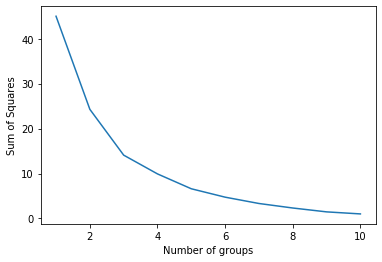

In [60]:
X = execute_1(result, 1, 10)


In [61]:
notification = execute_2(X, 5, indicator)